#  Assignment 3: Trajectory Planning

This notebook addresses the third home task in the **Fundamentals of Robotics** course. It includes:
- 📈 Generation of position, velocity, and acceleration trajectories
- ⏱️ Time synchronization for all joints
- ⚡ Trajectory sampling with control frequency (120 Hz)
- 🧮 Error propagation analysis
- 📍 Polynomial trajectory for 3 and 4 points
- 📐 Cartesian space trajectory (inverse Jacobian + sampling method)

> **Note:** This notebook continues from previous assignments. Plotting and animations are included where applicable.


$$
  \text{Fundamentals of Robotics — Assignment 3} \\
  \text{Valeria Neganova — RO-1} \\
  \text{2025}
$$

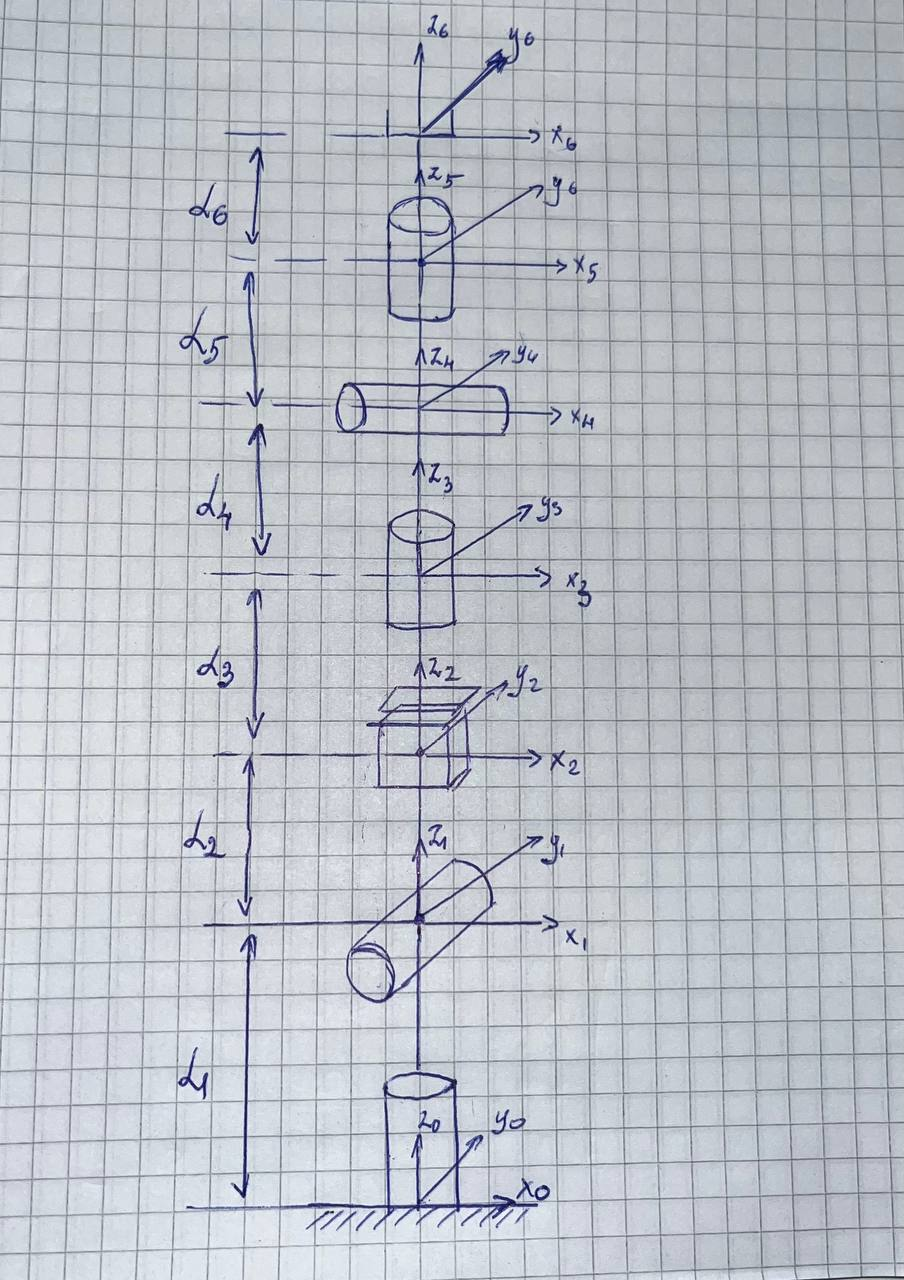

### Calculating and plotting position, velocity, and acceleration trajectories of driving my robot model from configuration q0 to configuration qf in joint space for minimum time

For moving from $q_0$ to $q_f$ in minimum possible time, with respect to $\dot q_{max}$ and $\ddot q_{max} $ we have two options: triangular or trapezoidal profile. Let's define the velocity and acceleration for the joints, the initial and final positions of the end effector, and  the physical constraints for the joints (needed to define the profile).

- Angular velocity = $25^\circ$ in $\text{second}$
- Angular acceleration = $5^\circ$ in $\text{second}^2$
- Linear velocity = $0.5$ $\text{cm/s}$
- Linear acceleration = $0.1$ $\text{cm/s}^2$

Let's define initial and final position :

In [ ]:
import sympy as sym

def Rx_sym(q):
    T = sym.Matrix([[1,         0,          0, 0],
                  [0, sym.cos(q), -sym.sin(q), 0],
                  [0, sym.sin(q),  sym.cos(q), 0],
                  [0,         0,          0, 1]])
    return T

def Ry_sym(q):
    T = sym.Matrix([[ sym.cos(q), 0, -sym.sin(q), 0],
                  [         0, 1,         0, 0],
                  [sym.sin(q), 0, sym.cos(q), 0],
                  [         0, 0,         0, 1]])
    return T

def Rz_sym(q):
    T = sym.Matrix([[sym.cos(q), -sym.sin(q), 0, 0],
                  [sym.sin(q),  sym.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]])
    return T

def Tx_sym(x):
    T = sym.Matrix([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T

def Ty_sym(y):
    T = sym.Matrix([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T

def Tz_sym(z):
    T = sym.Matrix([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]])
    return T


def dRz_sym(q):
            return sp.Matrix([
                [-sp.sin(q), -sp.cos(q), 0, 0],
                [ sp.cos(q), -sp.sin(q), 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0]
            ])
def dRy_sym(q):
  return sp.Matrix([
    [-sp.sin(q), 0,  sp.cos(q), 0],
    [0, 0, 0, 0],
    [-sp.cos(q), 0, -sp.sin(q), 0],
    [0, 0, 0, 0]
 ])

def dRx_sym(q):
  return sp.Matrix([
    [0, 0, 0, 0],
    [0, -sp.sin(q), -sp.cos(q), 0],
    [0,  sp.cos(q), -sp.sin(q), 0],
    [0, 0, 0, 0]
  ])




In [ ]:
import math
import random
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

initial_position = []
final_position = []
first_pos = []
second_pos = []
third_pos = []
fourth_pos = []

class RobotArm:
    def __init__(self):

        self.L1, self.L2, self.L3 = 10, 10, 10
        self.L4, self.L5, self.L6 = 5, 5, 5
        self.d3 = 5

        self.theta1, self.theta2, self.theta3, self.theta4, self.theta5, self.theta6 = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6', real=True)

        self.T01 = sp.Matrix([
            [sp.cos(self.theta1), -sp.sin(self.theta1), 0, 0],
            [sp.sin(self.theta1),  sp.cos(self.theta1), 0, 0],
            [0,0,1, self.L1],
            [0,0,0, 1]
        ])

        self.T12 = sp.Matrix([
            [sp.cos(self.theta2), 0, -sp.sin(self.theta2), -self.L2 * sp.sin(self.theta2)],
            [0, 1, 0, 0],
            [sp.sin(self.theta2), 0, sp.cos(self.theta2), self.L2 * sp.cos(self.theta2)],
            [0, 0, 0, 1]
        ])

        self.T23 = sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, self.d3 + self.L3],
            [0, 0, 0, 1]
        ])

        self.T34 = sp.Matrix([
            [sp.cos(self.theta4), -sp.sin(self.theta4), 0, 0],
            [sp.sin(self.theta4),  sp.cos(self.theta4), 0, 0],
            [0,0,1, self.L4],
            [0,0,0, 1]
        ])

        self.T45 = sp.Matrix([
            [1, 0, 0, 0],
            [0, sp.cos(self.theta5), -sp.sin(self.theta5), -self.L5 * sp.sin(self.theta5)],
            [0, sp.sin(self.theta5),  sp.cos(self.theta5), self.L5 * sp.cos(self.theta5)],
            [0, 0, 0, 1]
        ])

        self.T56 = sp.Matrix([
            [sp.cos(self.theta6), -sp.sin(self.theta6), 0, 0],
            [sp.sin(self.theta6),  sp.cos(self.theta6), 0, 0],
            [0,                   0,                  1, self.L6],
            [0, 0, 0, 1]
        ])


        self.T06_symbolic = sp.simplify(self.T01 * self.T12 * self.T23 * self.T34 * self.T45 * self.T56)


        self.current_joints = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    def forward_kinematics(self, joints):

        self.current_joints = joints

        subs_dict = {
            self.theta1: joints[0],
            self.theta2: joints[1],
            self.theta3: joints[2],
            self.theta4: joints[3],
            self.theta5: joints[4],
            self.theta6: joints[5]
        }
        T06_num = self.T06_symbolic.evalf(subs=subs_dict)
        return np.array(T06_num.tolist(), dtype=float)

    def inverse_kinematics_all(self, T06_num):
      solutions = []

      p = T06_num[0:3, 3]
      z6 = T06_num[0:3, 2]


      L6_eff = 10.0
      Pc = p - L6_eff * z6
      Px, Py, Pz = Pc[0], Pc[1], Pc[2]

      L1, L2 = self.L1, self.L2
      d3, L3 = self.d3, self.L3

      R = 30
      cos_t2 = (Pz - L1) / 30
      if abs(cos_t2) > 1.0:
          return solutions
      sin_t2_val = np.sqrt(1 - cos_t2**2)

      theta2_candidates = [np.arctan2(+sin_t2_val, cos_t2),
                            np.arctan2(-sin_t2_val, cos_t2)]

      for theta2 in theta2_candidates:
          sin_t2 = np.sin(theta2)
          if abs(sin_t2) < 1e-6:
              continue

          theta1 = np.arctan2(-Py/(R*sin_t2), -Px/(R*sin_t2))

          theta3 = self.d3

          R03 = np.array([
              [np.cos(theta1)*np.cos(theta2), -np.sin(theta1), -np.cos(theta1)*np.sin(theta2)],
              [np.sin(theta1)*np.cos(theta2),  np.cos(theta1), -np.sin(theta1)*np.sin(theta2)],
              [np.sin(theta2),                 0,              np.cos(theta2)]
          ])
          R06 = T06_num[:3, :3]
          R03_inv = np.linalg.inv(R03)
          R36 = R03_inv @ R06

          r13 = R36[0,2]
          r12 = R36[0,1]
          r22 = R36[1,1]
          r23 = R36[1,2]
          r33 = R36[2,2]
          r31 = R36[2,0]
          r32 = R36[2,1]



          # singular case consider
          if abs(r33 - 1) < 1e-5 or abs(r33 + 1) < 1e-5:
            if r33 > 0:
                theta4 = np.arctan2(r12, r22)
                theta6 = 0.0
            else:
                theta6 = -np.pi * np.arctan2(r12, r22)
                theta4 = 0.0
            theta5 = 0.0
            sol = (theta1, theta2, theta3, theta4, theta5, theta6)
            solutions.append(sol)
          else:
              cos_t5 = r33
              if abs(cos_t5) > 1:
                  cos_t5 = np.sign(cos_t5)
              sin_t5_val = np.sqrt(max(0, 1 - cos_t5**2))
              theta5_candidates = [np.arctan2(+sin_t5_val, cos_t5),
                                  np.arctan2(-sin_t5_val, cos_t5)]

              for theta5 in theta5_candidates:
                  if abs(np.sin(theta5)) < 1e-6:
                      theta4 = np.arctan2(r12, r22)
                      theta6 = 0.0
                  else:
                      sin_t5 = np.sin(theta5)
                      theta6 = np.arctan2(r31/sin_t5, r32/sin_t5)
                      theta4 = np.arctan2(r13/sin_t5, -r23/sin_t5)
                  sol = (theta1, theta2, theta3, theta4, theta5, theta6)
                  solutions.append(sol)

      return solutions




    def rad2deg(x):
        return round(math.degrees(x), 0)





    def get_all_frames(self, joints):

        subs_dict = {
        self.theta1: joints[0],
        self.theta2: joints[1],
        self.theta3: joints[2],
        self.theta4: joints[3],
        self.theta5: joints[4],
        self.theta6: joints[5]
        }


        T01_num = self.T01.evalf(subs=subs_dict)
        T12_num = self.T12.evalf(subs=subs_dict)
        T23_num = self.T23.evalf(subs=subs_dict)
        T34_num = self.T34.evalf(subs=subs_dict)
        T45_num = self.T45.evalf(subs=subs_dict)
        T56_num = self.T56.evalf(subs=subs_dict)


        T01_num = np.array(T01_num.tolist(), dtype=float)
        T12_num = np.array(T12_num.tolist(), dtype=float)
        T23_num = np.array(T23_num.tolist(), dtype=float)
        T34_num = np.array(T34_num.tolist(), dtype=float)
        T45_num = np.array(T45_num.tolist(), dtype=float)
        T56_num = np.array(T56_num.tolist(), dtype=float)

        T0_0 = np.eye(4)
        T0_1 = T0_0 @ T01_num

        T0_2 = T0_1 @ T12_num
        T0_3 = T0_2 @ T23_num
        T0_4 = T0_3 @ T34_num
        T0_5 = T0_4 @ T45_num
        T0_6 = T0_5 @ T56_num

        return [T0_0, T0_1, T0_2, T0_3, T0_4, T0_5, T0_6]

    def plot_robot(self, joints, ax=None, show_frames=True):

        frames = self.get_all_frames(joints)


        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            new_figure = True
        else:
            new_figure = False


        points = []
        for Ti in frames:
            px, py, pz = Ti[0, 3], Ti[1, 3], Ti[2, 3]
            points.append([px, py, pz])


        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        zs = [p[2] for p in points]
        ax.plot(xs, ys, zs, 'o-', color='blue', linewidth=2, markersize=5)


        if show_frames:
            for Ti in frames:
                self._draw_frame(ax, Ti, scale=3.0)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-20, 30])
        ax.set_ylim([-20, 30])
        ax.set_zlim([0, 40])


        if new_figure:
            plt.show()


    def _draw_frame(self, ax, T, scale=2.0):
      px, py, pz = T[0, 3], T[1, 3], T[2, 3]
      ux = T[0:3, 0]
      uy = T[0:3, 1]
      uz = T[0:3, 2]
      ax.quiver(px, py, pz, ux[0], ux[1], ux[2], color='r', length=scale)
      ax.quiver(px, py, pz, uy[0], uy[1], uy[2], color='g', length=scale)
      ax.quiver(px, py, pz, uz[0], uz[1], uz[2], color='b', length=scale)


    def jacobian_numeric(self):
        q1, q2, d3, q4, q5, q6 = self.current_joints
        L1, L2, L3, L4, L5, L6 = self.L1, self.L2, self.L3, self.L4, self.L5, self.L6



        H = Rz_sym(q1) @ Tz_sym(L1) @ Ry_sym(q2) @ Tz_sym(L2) @ Tz_sym(d3 + L3) @ Rz_sym(q4) @ Tz_sym(L4) @ \
            Rx_sym(q5) @ Tz_sym(L5) @ Rz_sym(q6) @ Tz_sym(L6)

        R = H[:3, :3]
        R_inv = R.T
        H_ee = sp.eye(4)
        H_ee[:3, :3] = R_inv


        H_ = dRz_sym(q1) @ Tz_sym(L1) @ Ry_sym(q2) @ Tz_sym(L2) @ Tz_sym(d3 + L3) @ Rz_sym(q4) @ Tz_sym(L4) @ \
             Rx_sym(q5) @ Tz_sym(L5) @ Rz_sym(q6) @ Tz_sym(L6) @ H_ee
        J1 = sp.Matrix([H_[0,3], H_[1,3], H_[2,3], H_[2,1], H_[0,2], H_[1,0]])


        H_ = Rz_sym(q1) @ Tz_sym(L1) @ dRy_sym(q2) @ Tz_sym(L2) @ Tz_sym(d3 + L3) @ Rz_sym(q4) @ Tz_sym(L4) @ \
             Rx_sym(q5) @ Tz_sym(L5) @ Rz_sym(q6) @ Tz_sym(L6) @ H_ee
        J2 = sp.Matrix([H_[0,3], H_[1,3], H_[2,3], H_[2,1], H_[0,2], H_[1,0]])


        H_ = Rz_sym(q1) @ Tz_sym(L1) @ Ry_sym(q2) @ Tz_sym(L2) @ sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0]
        ]) @ Rz_sym(q4) @ Tz_sym(L4) @ Rx_sym(q5) @ Tz_sym(L5) @ Rz_sym(q6) @ Tz_sym(L6) @ H_ee
        J3 = sp.Matrix([H_[0,3], H_[1,3], H_[2,3], 0, 0, 0])


        H_ = Rz_sym(q1) @ Tz_sym(L1) @ Ry_sym(q2) @ Tz_sym(L2) @ Tz_sym(d3 + L3) @ dRz_sym(q4) @ Tz_sym(L4) @ \
             Rx_sym(q5) @ Tz_sym(L5) @ Rz_sym(q6) @ Tz_sym(L6) @ H_ee
        J4 = sp.Matrix([H_[0,3], H_[1,3], H_[2,3], H_[2,1], H_[0,2], H_[1,0]])


        H_ = Rz_sym(q1) @ Tz_sym(L1) @ Ry_sym(q2) @ Tz_sym(L2) @ Tz_sym(d3 + L3) @ Rz_sym(q4) @ Tz_sym(L4) @ \
             dRx_sym(q5) @ Tz_sym(L5) @ Rz_sym(q6) @ Tz_sym(L6) @ H_ee
        J5 = sp.Matrix([H_[0,3], H_[1,3], H_[2,3], H_[2,1], H_[0,2], H_[1,0]])

        H_ = Rz_sym(q1) @ Tz_sym(L1) @ Ry_sym(q2) @ Tz_sym(L2) @ Tz_sym(d3 + L3) @ Rz_sym(q4) @ Tz_sym(L4) @ \
             Rx_sym(q5) @ Tz_sym(L5) @ dRz_sym(q6) @ Tz_sym(L6) @ H_ee
        J6 = sp.Matrix([H_[0,3], H_[1,3], H_[2,3], H_[2,1], H_[0,2], H_[1,0]])


        J = sp.Matrix.hstack(J1, J2, J3, J4, J5, J6)
        J_num = np.array(J.evalf(), dtype=float)
        return J_num.round(2)




def main():
    global initial_position, final_position, first_pos, second_pos, third_pos, fourth_pos
    #random.seed(0)
    n_tests = 4
    robot = RobotArm()
    success_count = 0
    final_valid_solution = None

    for test in range(n_tests):

        t1_in = math.radians(random.uniform(-180, 180))
        t2_in = math.radians(random.uniform(-180, 180))
        t3_in = 0.0
        t4_in = math.radians(random.uniform(-180, 180))
        t5_in = math.radians(random.uniform(-180, 180))
        t6_in = math.radians(random.uniform(-180, 180))

        input_angles = [t1_in, t2_in, t3_in, t4_in, t5_in, t6_in]
        T06_in = robot.forward_kinematics(input_angles)
        solutions = robot.inverse_kinematics_all(T06_in)

        valid_solutions = []

        for sol in solutions:
            T06_sol = robot.forward_kinematics(sol)
            diff = np.max(np.abs(T06_sol - T06_in))
            if diff < 0.01:
                valid_solutions.append(sol)
                success_count += 1

        if valid_solutions:
            differences = [np.linalg.norm(np.array(sol) - np.array(input_angles)) for sol in valid_solutions]
            min_index = np.argmin(differences)
            final_valid_solution = valid_solutions[min_index]
            robot.current_joints = final_valid_solution
            if (success_count/4 == 1):
              initial_position = [np.round(t1_in,2).tolist(), np.round(t2_in,2).tolist(), np.round(0,2).tolist(), np.round(t4_in,2).tolist(), np.round(t5_in,2).tolist(), np.round(t6_in,2).tolist()]
              first_pos = initial_position
              print("Initial position", initial_position)
            if (success_count/4 == 2):
              print("Final position", np.round(np.array(final_valid_solution), 2).tolist())
              final_position = np.round(np.array(final_valid_solution), 2).tolist()
              second_pos = final_position


            if (success_count/4 == 3):
              third_pos = np.round(np.array(final_valid_solution), 2).tolist()
            if (success_count/4 == 4):
              fourth_pos = np.round(np.array(final_valid_solution), 2).tolist()





        in_angles_deg = [RobotArm.rad2deg(a) for a in input_angles]



    print("\nJacobian matrix for the final found solution:")
    J = robot.jacobian_numeric()
    print(J)





if __name__ == '__main__':
    main()


Initial position [-2.79, -1.36, 0, -0.94, -2.35, -0.09]
Final position [0.01, -2.12, 5.0, -2.52, -0.01, 0.87]

Jacobian matrix for the final found solution:
[[ -9.11 -17.46   5.54  -2.46   8.71   0.  ]
 [ 29.67  -7.98  -1.92   8.91   3.75   0.  ]
 [  0.   -24.14  -8.14  -3.77   3.17   0.  ]
 [  0.    -0.31   0.     0.85   0.25   0.42]
 [  0.     0.67   0.     0.39  -0.89  -0.25]
 [  1.    -0.26   0.     0.36   0.38  -0.87]]


Let's define profiles for each joint :    

$$
\dot{q}_{\text{max}} \sqrt{\ddot{q}_{\text{max}} \cdot (q_f - q_0)} \leq \dot{q}^{physical}_{\text{max}} \quad \Rightarrow \quad \textit{Triangular profile}
$$

$$
\dot{q}_{\text{max}} \sqrt{\ddot{q}_{\text{max}} \cdot (q_f - q_0)} > \dot{q}^{physical}_{\text{max}} \quad \Rightarrow \quad \textit{Trapezoidal profile}
$$




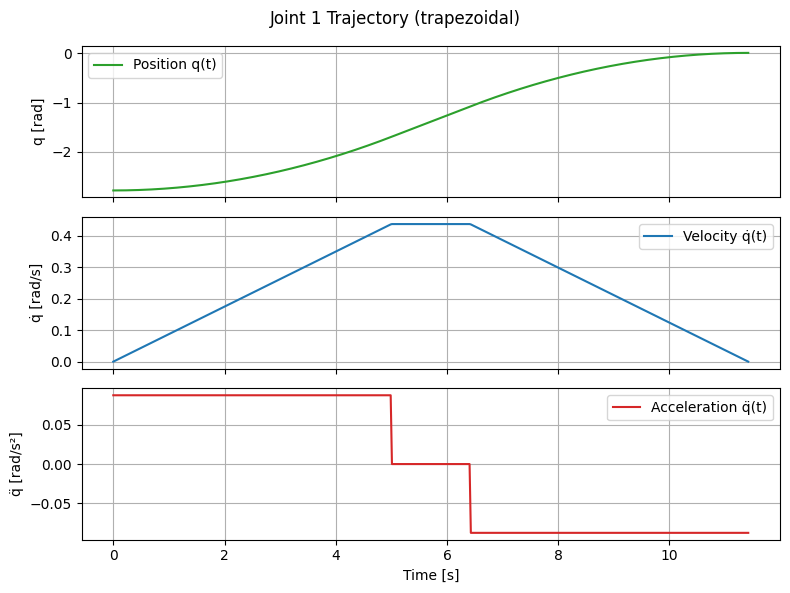

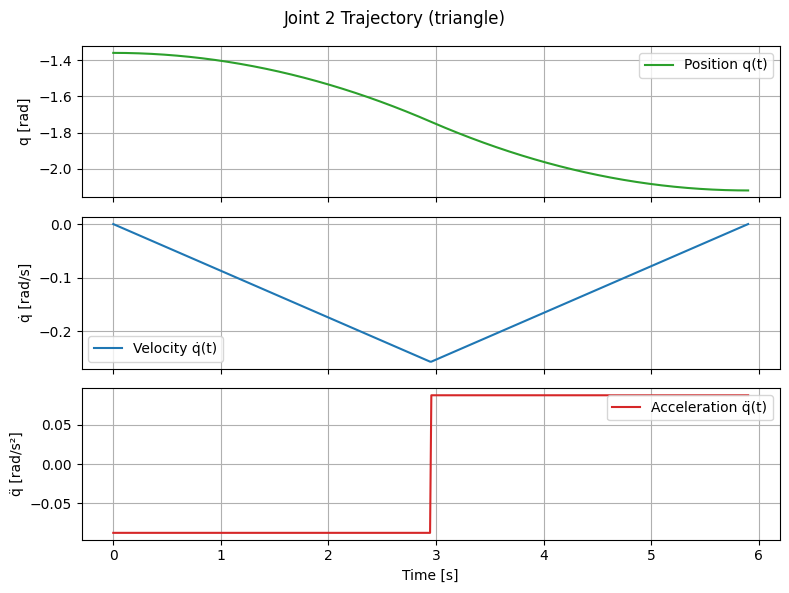

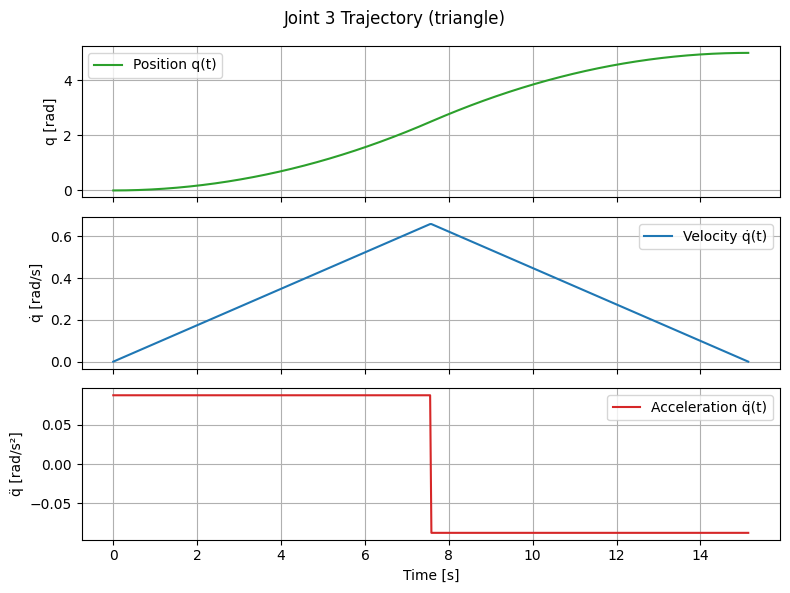

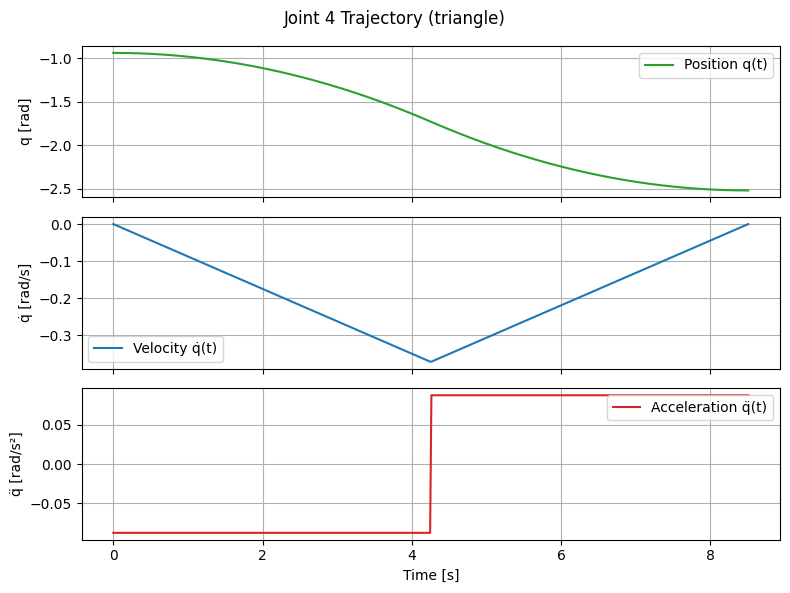

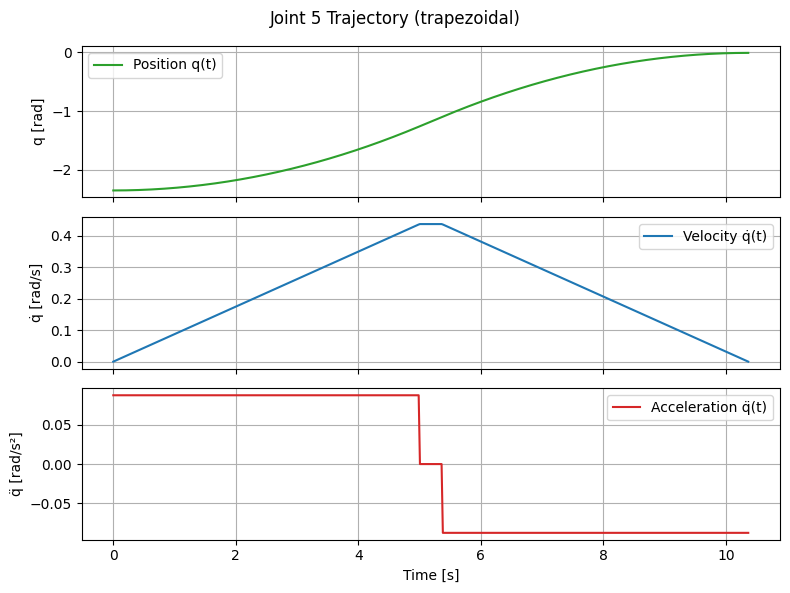

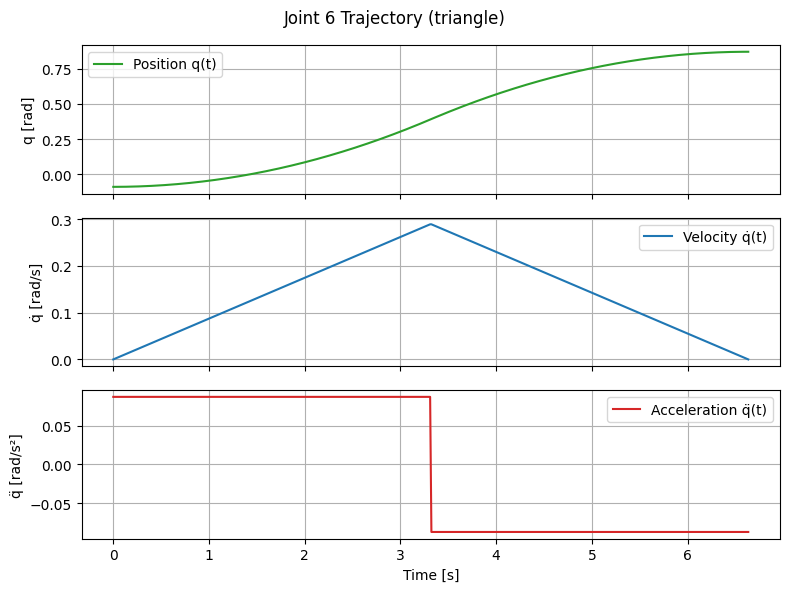

In [ ]:
import matplotlib.pyplot as plt

joint_profiles = []


q_dot =  np.deg2rad(25)
q_ddot = np.deg2rad(5)

for i in range(6):
    q0 = initial_position[i]
    qf = final_position[i]
    dq = qf - q0
    sign = np.sign(dq)
    dq = abs(dq)


    if i != 2:
        v_test = np.sqrt(q_ddot * dq)

        if v_test <= q_dot:
            profile = "triangle"
            tf = 2 * np.sqrt(dq / q_ddot)
            tb = tf / 2

        else:
            profile = "trapezoidal"
            tb = q_dot / q_ddot
            tf = dq / q_dot + tb
    else:
        profile = "triangle"
        tf = 2 * np.sqrt(dq / q_ddot)
        tb = tf / 2



    t = np.linspace(0, tf, 500)
    qd = np.zeros_like(t)
    q = np.zeros_like(t)
    qdd = np.zeros_like(t)



    for j, tj in enumerate(t):
      if profile == "triangle":

            if tj <= tb:
                q[j] =  q0 + (0.5 * q_ddot * tj**2) * sign
                qd[j] =   sign * q_ddot * tj
                qdd[j] = sign * q_ddot

            else:
                q[j] = qf - (0.5 * q_ddot * (tf - tj)**2) * sign
                qd[j] = sign * q_ddot * (tf - tj)
                qdd[j] = -sign * q_ddot

      else:

            if tj <= tb:
              q[j] = q0 + (0.5 * q_ddot * tj**2) * sign
              qd[j] = sign * q_ddot * tj
              qdd[j] = sign * q_ddot

            elif tj <= tf - tb:
              q[j] = q0 + 0.5 * sign * q_ddot * tb**2 + q_dot*(tj - tb) * sign
              qd[j] = sign * q_dot
              qdd[j] = 0

            else:
              q[j] = qf - 0.5 * sign * q_ddot * (tf - tj)**2
              qd[j] = sign * q_ddot * (tf - tj)
              qdd[j] = -sign * q_ddot

    joint_profiles.append(q[-1])

    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"Joint {i+1} Trajectory ({profile})")

    axs[0].plot(t, q, label='Position q(t)', color='tab:green')
    axs[0].set_ylabel("q [rad]")
    axs[0].grid(True)

    axs[1].plot(t, qd, label='Velocity q̇(t)', color='tab:blue')
    axs[1].set_ylabel("q̇ [rad/s]")
    axs[1].grid(True)

    axs[2].plot(t, qdd, label='Acceleration q̈(t)', color='tab:red')
    axs[2].set_ylabel("q̈ [rad/s²]")
    axs[2].set_xlabel("Time [s]")
    axs[2].grid(True)

    for ax in axs:
        ax.legend()

    plt.tight_layout()
    plt.show()





### Synchronize  6 joints to start and end motion at the same time

- Calculate  $t_f$ for each joint
- Find max $t_f$
- Recalculate $t_f$ of each joint relatively to max $t_f$

For triangle profile:

$$\ddot q_{max} = \frac{4Δq}{t_f}$$

$$\dot q_{max} = \frac{\ddot q_{max}t_f }{2}$$

If $\ddot q_{max}$ and $\dot q_{max}$ satisfy for conditions(smaller or equal to phesical restrictions) - triangular profile6 in other cases - trapesoidal

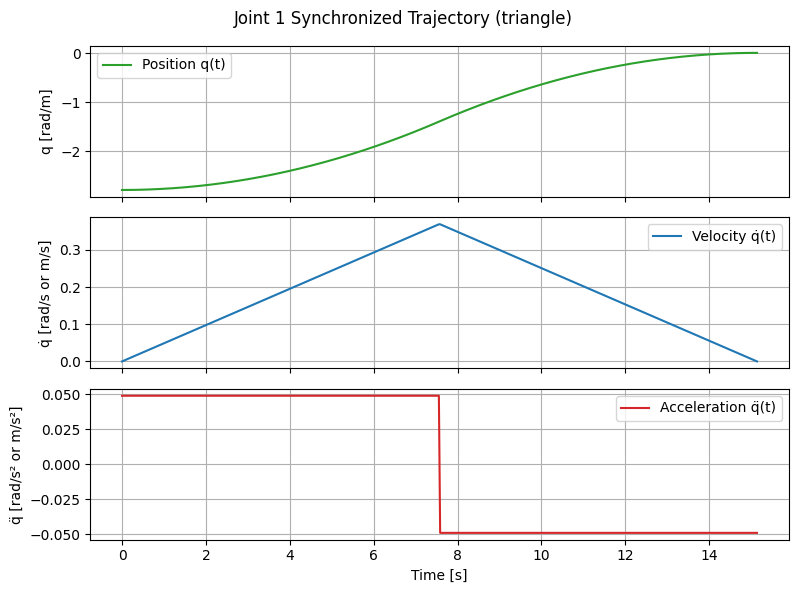

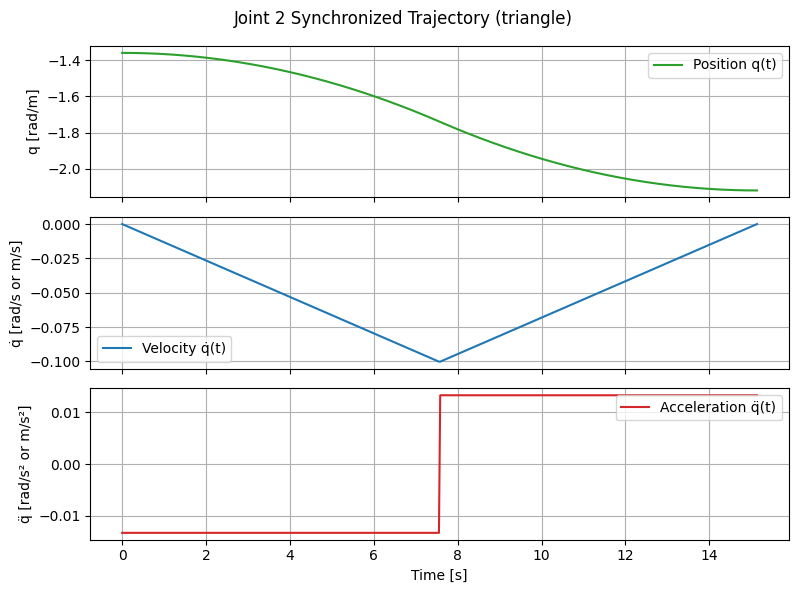

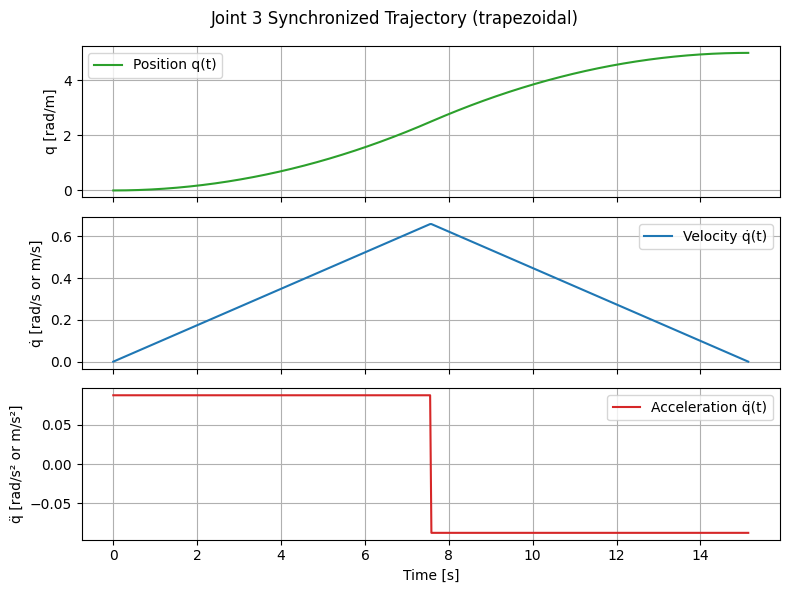

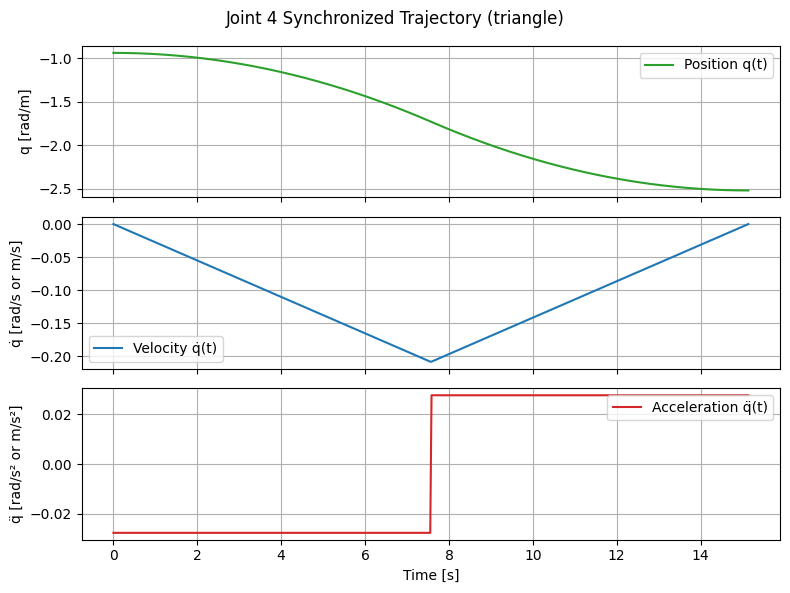

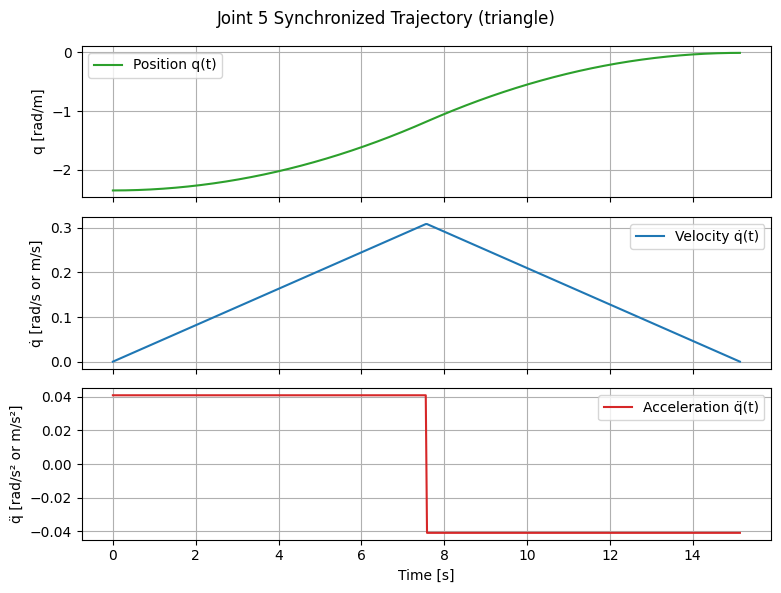

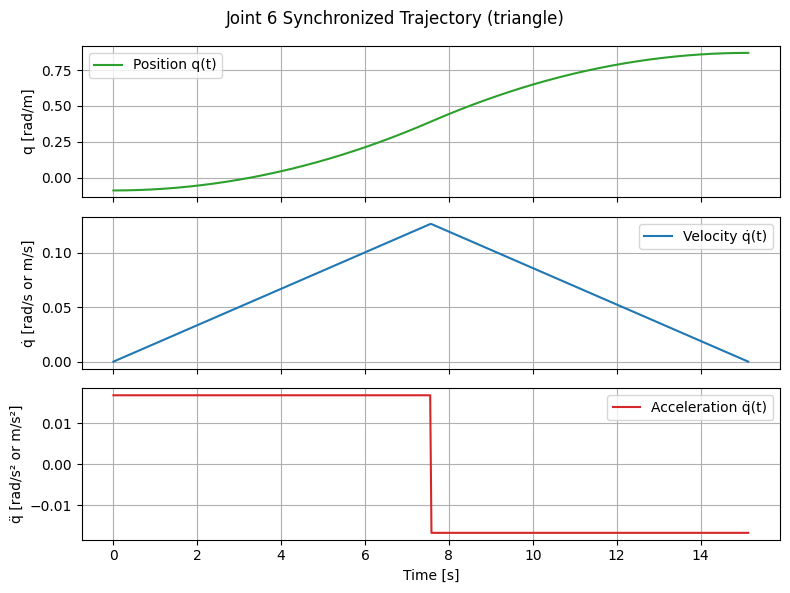

In [ ]:

q_dot_max = np.deg2rad(25)
q_ddot_max = np.deg2rad(5)

joint_data = []

for i in range(6):
    q0 = initial_position[i]
    qf = final_position[i]
    dq = qf - q0
    sign = np.sign(dq)
    dq_abs = abs(dq)

    if i != 2:
        v_test = np.sqrt(q_ddot_max * dq_abs)
        if v_test <= q_dot_max:
            tf = 2 * np.sqrt(dq_abs / q_ddot_max)
        else:
            tb = q_dot_max / q_ddot_max
            tf = dq_abs / q_dot_max + tb
    else:
        tf = 2 * np.sqrt(dq_abs / q_ddot_max)

    joint_data.append({
        "q0": q0,
        "qf": qf,
        "dq": dq_abs,
        "sign": sign,
        "tf_local": tf
    })

T_sync = max(j["tf_local"] for j in joint_data)

for i, joint in enumerate(joint_data):
    q0, qf, dq, sign = joint["q0"], joint["qf"], joint["dq"], joint["sign"]
    T = T_sync


    # check if triangle profile
    qdd_test = 4*dq / T**2
    q_dot_test = qdd_test * T / 2

    if q_dot_test <= q_dot_max and qdd_test <= q_ddot_max:

        profile = "triangle"
        tb = T / 2
        q_ddot = qdd_test
    else:
        profile = "trapezoidal"
        tb = (T - np.sqrt(T**2 - 4 * dq / q_ddot_max)) / 2
        q_dot = dq / (T - tb)
        q_ddot = q_dot / tb


    t = np.linspace(0, T, 500)
    q = np.zeros_like(t)
    qd = np.zeros_like(t)
    qdd = np.zeros_like(t)

    for j, tj in enumerate(t):
        if profile == "triangle":
            if tj <= tb:
                q[j] = q0 + 0.5 * q_ddot * tj**2 * sign
                qd[j] = q_ddot * tj * sign
                qdd[j] = q_ddot * sign
            else:
                q[j] = qf - 0.5 * q_ddot * (T - tj)**2 * sign
                qd[j] = q_ddot * (T - tj) * sign
                qdd[j] = -q_ddot * sign
        else:
            if tj <= tb:
                q[j] = q0 + 0.5 * q_ddot * tj**2 * sign
                qd[j] = q_ddot * tj * sign
                qdd[j] = q_ddot * sign
            elif tj <= T - tb:
                q[j] = q0 + 0.5 * q_ddot * tb**2 * sign + (tj - tb) * q_dot * sign
                qd[j] = q_dot * sign
                qdd[j] = 0
            else:
                q[j] = qf - 0.5 * q_ddot * (T - tj)**2 * sign
                qd[j] = q_ddot * (T - tj) * sign
                qdd[j] = -q_ddot * sign

    # Построение графиков
    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"Joint {i+1} Synchronized Trajectory ({profile})")

    axs[0].plot(t, q, label='Position q(t)', color='tab:green')
    axs[0].set_ylabel("q [rad/m]")
    axs[0].grid(True)

    axs[1].plot(t, qd, label='Velocity q̇(t)', color='tab:blue')
    axs[1].set_ylabel("q̇ [rad/s or m/s]")
    axs[1].grid(True)

    axs[2].plot(t, qdd, label='Acceleration q̈(t)', color='tab:red')
    axs[2].set_ylabel("q̈ [rad/s² or m/s²]")
    axs[2].set_xlabel("Time [s]")
    axs[2].grid(True)

    for ax in axs:
        ax.legend()

    plt.tight_layout()
    plt.show()


### Considering 120 Hz frequency of controller

It means, that our controller receives signals 120 times per second. Therefore, each discrete step in time is $$Δt = \frac{1}{120} ≈ 8.33 \text{ms}$$

*$\text{ms}$ - mili-seconds*



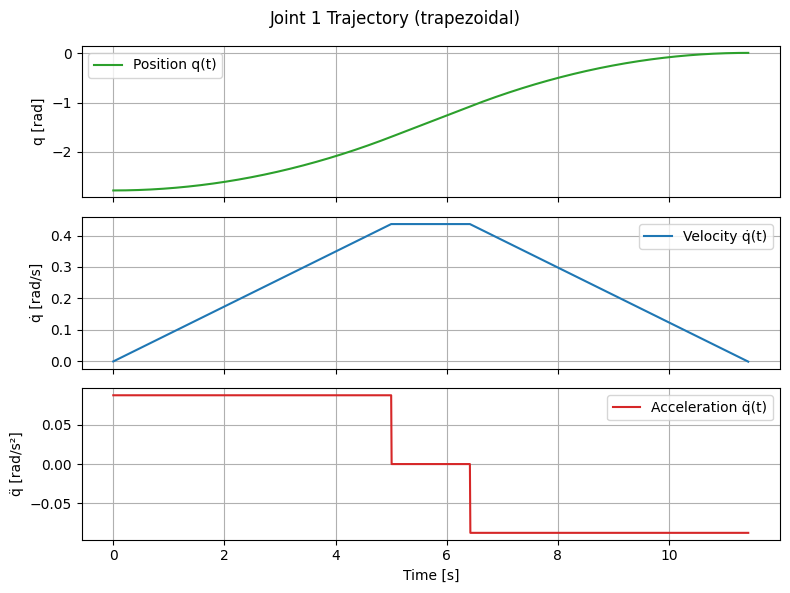

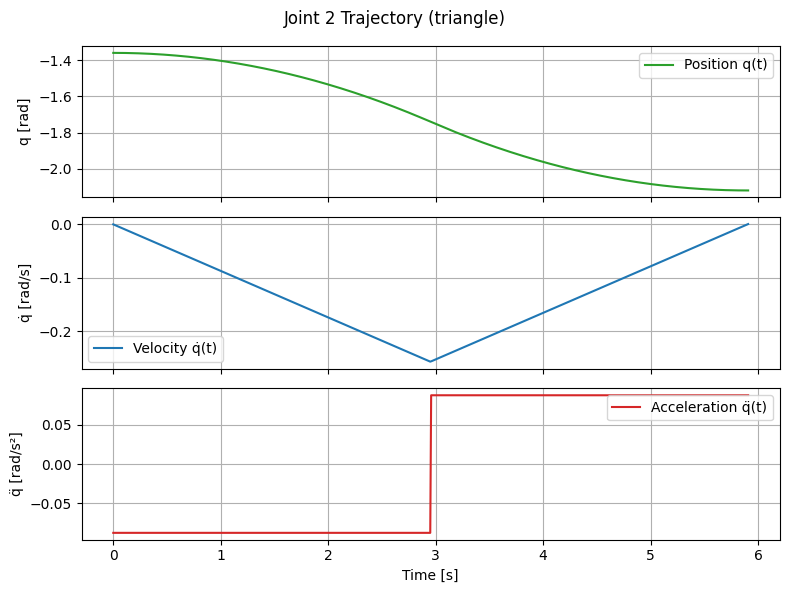

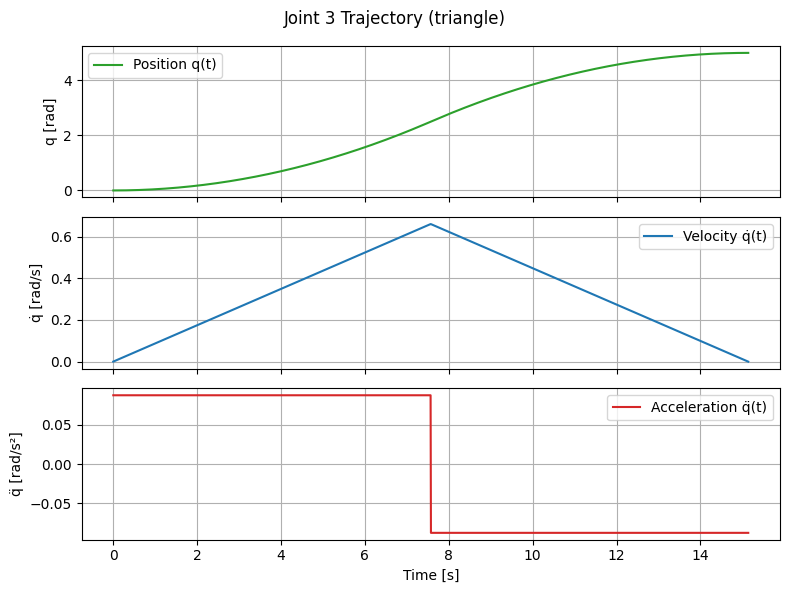

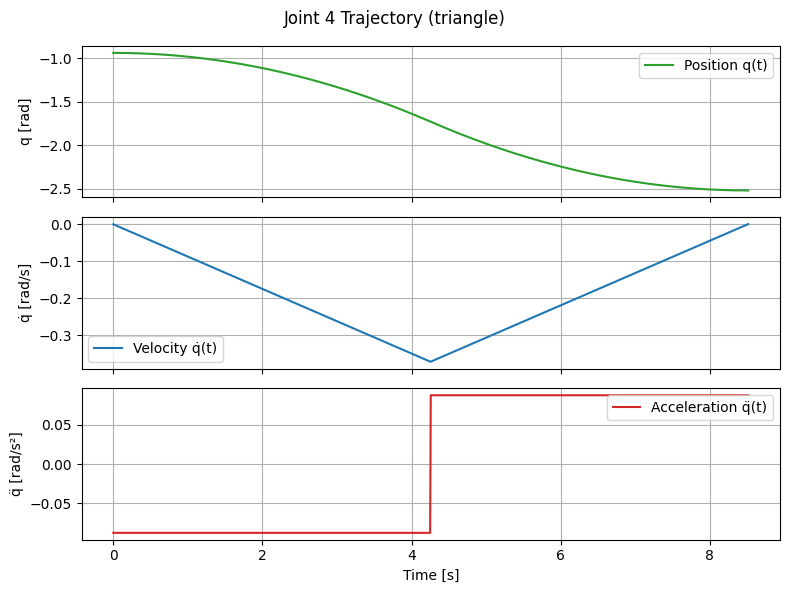

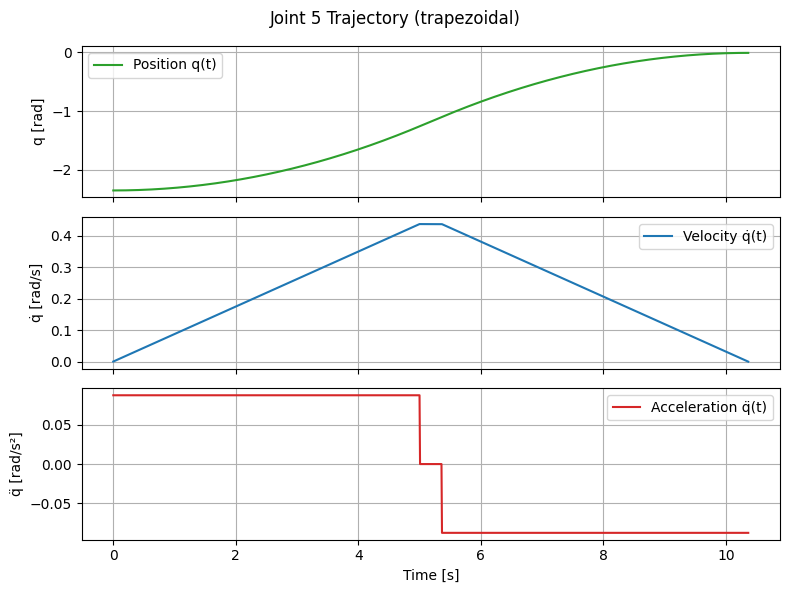

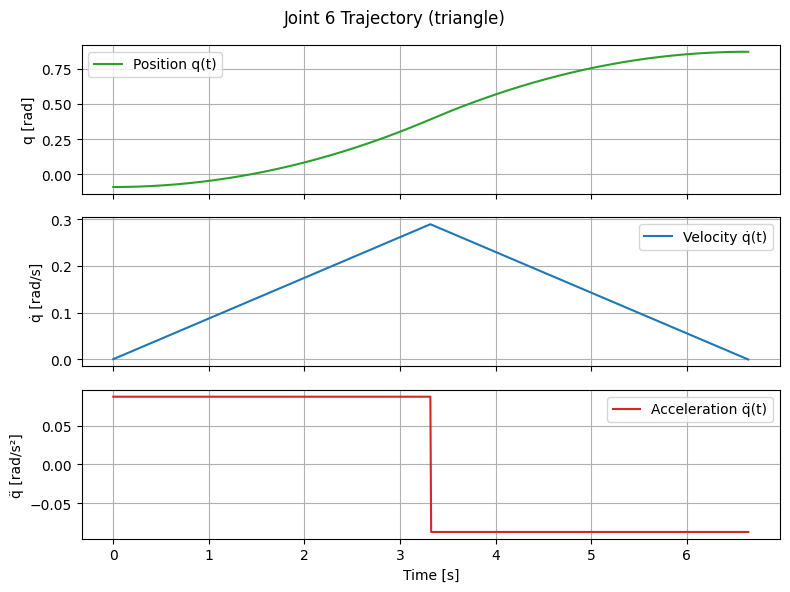

In [ ]:
import matplotlib.pyplot as plt

joint_profiles = []


q_dot =  np.deg2rad(25)
q_ddot = np.deg2rad(5)

for i in range(6):
    q0 = initial_position[i]
    qf = final_position[i]
    dq = qf - q0
    sign = np.sign(dq)
    dq = abs(dq)


    if i != 2:
        v_test = np.sqrt(q_ddot * dq)

        if v_test <= q_dot:
            profile = "triangle"
            tf = 2 * np.sqrt(dq / q_ddot)
            tb = tf / 2

        else:
            profile = "trapezoidal"
            tb = q_dot / q_ddot
            tf = dq / q_dot + tb
    else:
        profile = "triangle"
        tf = 2 * np.sqrt(dq / q_ddot)
        tb = tf / 2


    dt = 1/120
    N = math.ceil(tf/dt)
    t = np.linspace(0, N * dt, N + 1)
    qd = np.zeros_like(t)
    q = np.zeros_like(t)
    qdd = np.zeros_like(t)



    for j, tj in enumerate(t):
      if profile == "triangle":

            if tj <= tb:
                q[j] =  q0 + (0.5 * q_ddot * tj**2) * sign
                qd[j] =   sign * q_ddot * tj
                qdd[j] = sign * q_ddot

            else:
                q[j] = qf - (0.5 * q_ddot * (tf - tj)**2) * sign
                qd[j] = sign * q_ddot * (tf - tj)
                qdd[j] = -sign * q_ddot

      else:

            if tj <= tb:
              q[j] = q0 + (0.5 * q_ddot * tj**2) * sign
              qd[j] = sign * q_ddot * tj
              qdd[j] = sign * q_ddot

            elif tj <= tf - tb:
              q[j] = q0 + 0.5 * sign * q_ddot * tb**2 + q_dot*(tj - tb) * sign
              qd[j] = sign * q_dot
              qdd[j] = 0

            else:
              q[j] = qf - 0.5 * sign * q_ddot * (tf - tj)**2
              qd[j] = sign * q_ddot * (tf - tj)
              qdd[j] = -sign * q_ddot

    joint_profiles.append(q[-1])

    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"Joint {i+1} Trajectory ({profile})")

    axs[0].plot(t, q, label='Position q(t)', color='tab:green')
    axs[0].set_ylabel("q [rad]")
    axs[0].grid(True)

    axs[1].plot(t, qd, label='Velocity q̇(t)', color='tab:blue')
    axs[1].set_ylabel("q̇ [rad/s]")
    axs[1].grid(True)

    axs[2].plot(t, qdd, label='Acceleration q̈(t)', color='tab:red')
    axs[2].set_ylabel("q̈ [rad/s²]")
    axs[2].set_xlabel("Time [s]")
    axs[2].grid(True)

    for ax in axs:
        ax.legend()

    plt.tight_layout()
    plt.show()





### Calculating propagated error in end-effector possition (with continious trajectory)

To evaluate the accuracy of trajectory planning, we compare the final joint positions after executing continuous-time profiles with the originally planned final joint positions.



*In continuous case I already calculate positions of joints after applying profiles. Let's compare results*

In [ ]:
print("\nPlanned final results:")
print(np.round(final_position, 10))

print("\nFinal results from profiles:")
print(np.round(joint_profiles, 10))


errors = np.abs(np.array(final_position) - np.array(joint_profiles))
print("\nError:")
print(np.round(errors, 6))


Planned final results:
[ 0.01 -2.12  5.   -2.52 -0.01  0.87]

Final results from profiles:
[ 0.0099973  -2.11999835  4.99999964 -2.51999812 -0.01000062  0.86999708]

Error:
[3.e-06 2.e-06 0.e+00 2.e-06 1.e-06 3.e-06]


We have a small error, but overall robot follows to planned trajectory very well

### Redefine synchronized trajectories for numerical control

For redefining I use   synchronization code from (2)nd task. Also I add 120Hz as frequency for numercial control

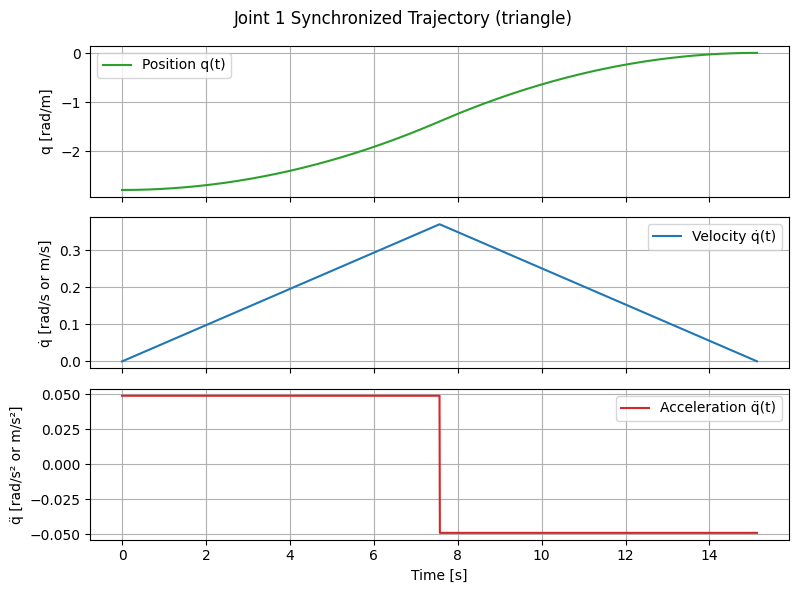

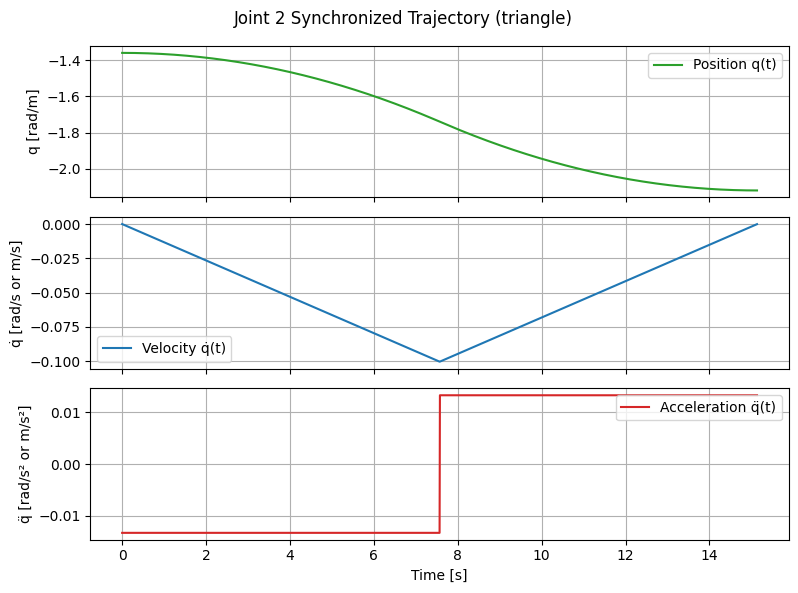

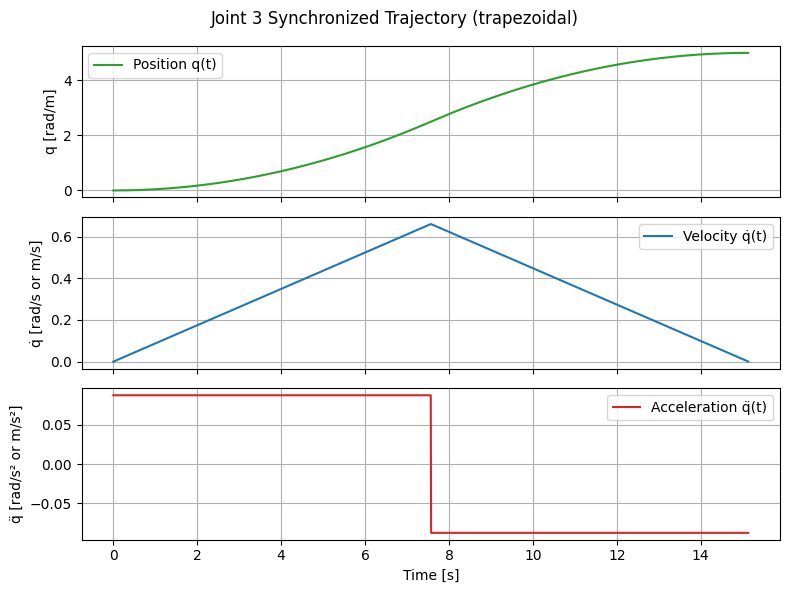

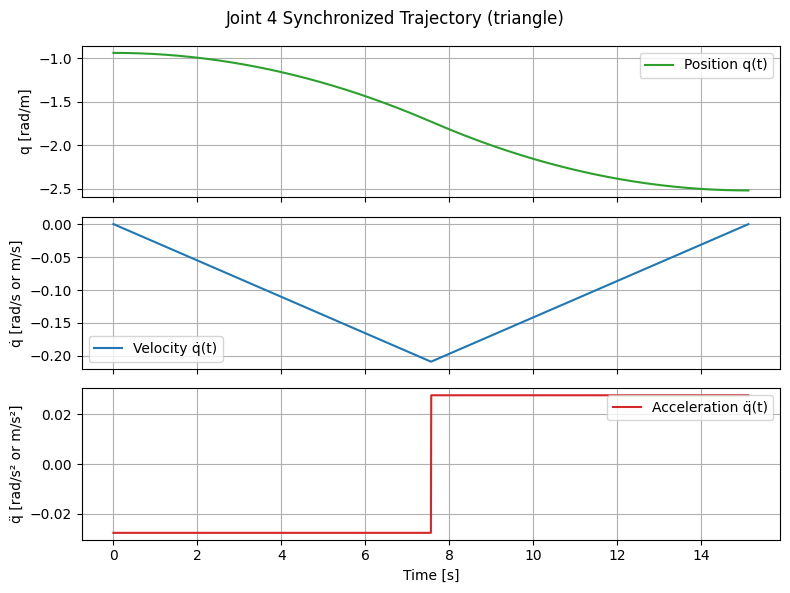

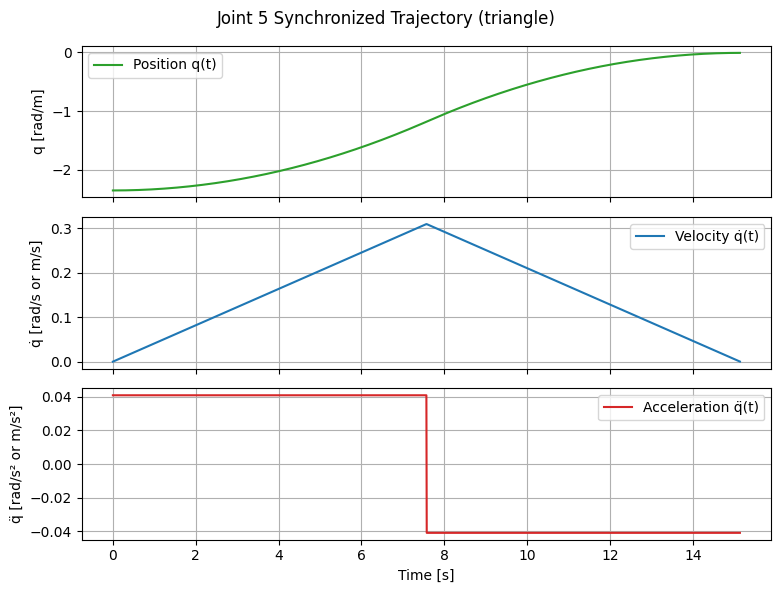

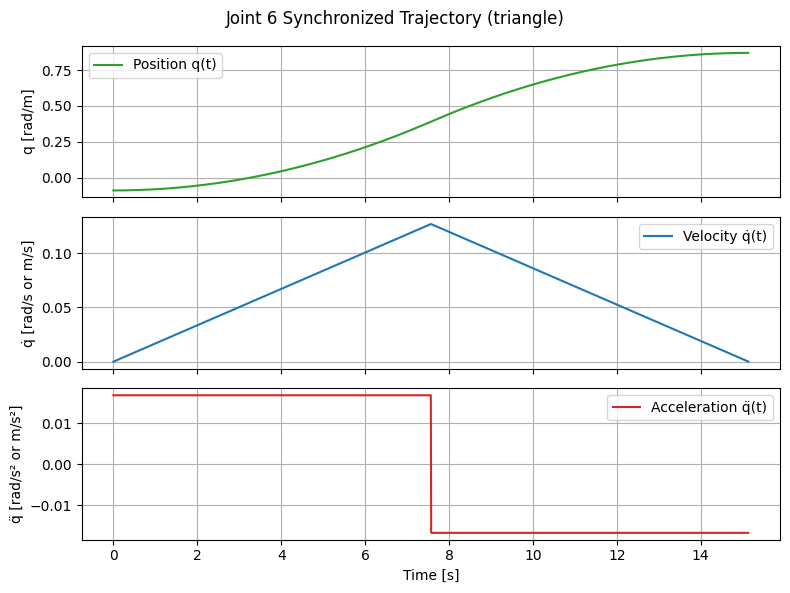

In [ ]:

q_dot_max = np.deg2rad(25)
q_ddot_max = np.deg2rad(5)

joint_data = []

for i in range(6):
    q0 = initial_position[i]
    qf = final_position[i]
    dq = qf - q0
    sign = np.sign(dq)
    dq_abs = abs(dq)

    if i != 2:
        v_test = np.sqrt(q_ddot_max * dq_abs)
        if v_test <= q_dot_max:
            tf = 2 * np.sqrt(dq_abs / q_ddot_max)
        else:
            tb = q_dot_max / q_ddot_max
            tf = dq_abs / q_dot_max + tb
    else:
        tf = 2 * np.sqrt(dq_abs / q_ddot_max)

    joint_data.append({
        "q0": q0,
        "qf": qf,
        "dq": dq_abs,
        "sign": sign,
        "tf_local": tf
    })

T_sync = max(j["tf_local"] for j in joint_data)

for i, joint in enumerate(joint_data):
    q0, qf, dq, sign = joint["q0"], joint["qf"], joint["dq"], joint["sign"]
    T = T_sync


    # check if triangle profile
    qdd_test = 4*dq / T**2
    q_dot_test = qdd_test * T / 2

    if q_dot_test <= q_dot_max and qdd_test <= q_ddot_max:
        profile = "triangle"
        tb = T / 2
        q_ddot = qdd_test
    else:
        profile = "trapezoidal"
        tb = (T - np.sqrt(T**2 - 4 * dq / q_ddot_max)) / 2
        q_dot = dq / (T - tb)
        q_ddot = q_dot / tb

    #120Hz
    dt = 1 / 120
    N = math.ceil(T / dt)
    t = np.arange(0, N * dt, dt)
    q = np.zeros_like(t)
    qd = np.zeros_like(t)
    qdd = np.zeros_like(t)

    for j, tj in enumerate(t):
        if profile == "triangle":
            if tj <= tb:
                q[j] = q0 + 0.5 * q_ddot * tj**2 * sign
                qd[j] = q_ddot * tj * sign
                qdd[j] = q_ddot * sign
            else:
                q[j] = qf - 0.5 * q_ddot * (T - tj)**2 * sign
                qd[j] = q_ddot * (T - tj) * sign
                qdd[j] = -q_ddot * sign

        else:
            if tj <= tb:
                q[j] = q0 + 0.5 * q_ddot * tj**2 * sign
                qd[j] = q_ddot * tj * sign
                qdd[j] = q_ddot * sign
            elif tj <= T - tb:
                q[j] = q0 + 0.5 * q_ddot * tb**2 * sign + (tj - tb) * q_dot * sign
                qd[j] = q_dot * sign
                qdd[j] = 0
            else:
                q[j] = qf - 0.5 * q_ddot * (T - tj)**2 * sign
                qd[j] = q_ddot * (T - tj) * sign
                qdd[j] = -q_ddot * sign


    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"Joint {i+1} Synchronized Trajectory ({profile})")

    axs[0].plot(t, q, label='Position q(t)', color='tab:green')
    axs[0].set_ylabel("q [rad/m]")
    axs[0].grid(True)

    axs[1].plot(t, qd, label='Velocity q̇(t)', color='tab:blue')
    axs[1].set_ylabel("q̇ [rad/s or m/s]")
    axs[1].grid(True)

    axs[2].plot(t, qdd, label='Acceleration q̈(t)', color='tab:red')
    axs[2].set_ylabel("q̈ [rad/s² or m/s²]")
    axs[2].set_xlabel("Time [s]")
    axs[2].grid(True)

    for ax in axs:
        ax.legend()

    plt.tight_layout()
    plt.show()


### Drive  robot model between 3 consequent points. (Solve polynomial)

This code calculates and plots 2nd-degree polynomial trajectories for 6 joints based on position data at three time points.

####  Why use a 2nd-degree polynomial?

- Simple and efficient to compute
- Ensures smooth position and velocity (acceleration is constant)
- Suitable for interpolation through three known positions
- Useful for initial trajectory planning in robotic manipulators

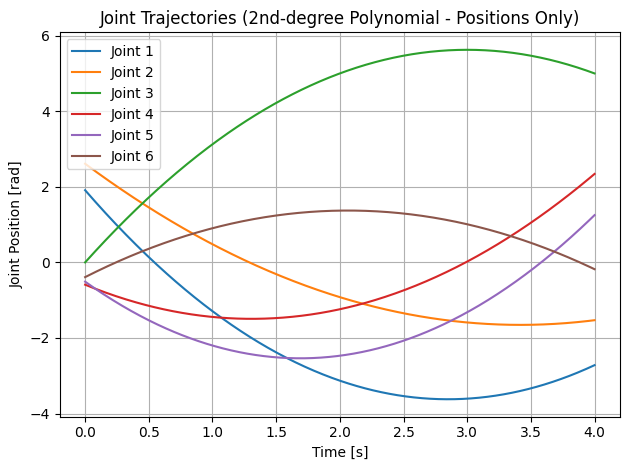

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q1 = [1.91, 2.61, 0.0, -0.59, -0.51, -0.39]
q2 = [-3.13, -0.92, 5.0, -1.24, -2.47, 1.37]
q3 = [-2.72, -1.53, 5.0, 2.34, 1.25, -0.18]

t0, t1, t2 = 0, 2, 4
t_vals = np.linspace(t0, t2, 500)

for joint in range(6):
    A = np.array([
        [1, t0, t0**2],
        [1, t1, t1**2],
        [1, t2, t2**2]
    ])
    b = np.array([q1[joint], q2[joint], q3[joint]])

    coeffs = np.linalg.solve(A, b)

    q_vals = np.polyval(coeffs[::-1], t_vals)

    plt.plot(t_vals, q_vals, label=f'Joint {joint+1}')

plt.title("Joint Trajectories (2nd-degree Polynomial - Positions Only)")
plt.xlabel("Time [s]")
plt.ylabel("Joint Position [rad]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Solve polynomial constraining null value for initial and final acceleration passing through 4 consequent points

This script computes joint trajectories for a 6-DOF manipulator using a **5th-degree polynomial**.  
It passes through 4 known joint positions (`q1`, `q2`, `q3`, `q4`) at times `t = 0, 2, 4, 6` seconds.  
Additionally, the trajectory is constrained to have **zero acceleration** at the start (`t=0`) and end (`t=6`),  
ensuring smooth motion without sudden forces or jerks.

Key constraints:
- $ q(t_0), q(t_1), q(t_2), q(t_3) $ — known positions
- $ \ddot{q}(t_0) = 0 $, $\ddot{q}(t_3) = 0 $ — zero acceleration at endpoints


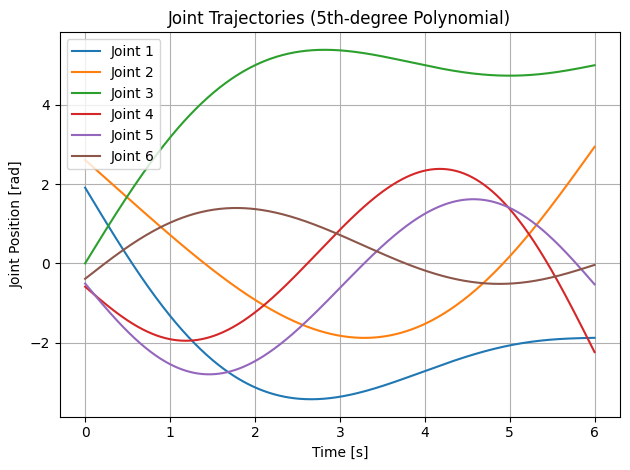

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q1 = [1.91, 2.61, 0.0, -0.59, -0.51, -0.39]
q2 = [-3.13, -0.92, 5.0, -1.24, -2.47, 1.37]
q3 = [-2.72, -1.53, 5.0, 2.34, 1.25, -0.18]
q4 = [-1.88, 2.94, 5.0, -2.24, -0.53, -0.04]

t0, t1, t2, t3 = 0, 2, 4, 6
t_vals = np.linspace(t0, t3, 500)

for joint in range(6):
    A = np.array([
        [1, t0, t0**2, t0**3,     t0**4,     t0**5],
        [1, t1, t1**2, t1**3,     t1**4,     t1**5],
        [1, t2, t2**2, t2**3,     t2**4,     t2**5],
        [1, t3, t3**2, t3**3,     t3**4,     t3**5],
        [0, 0,    2,   6*t0, 12*t0**2, 20*t0**3],
        [0, 0,    2,   6*t3, 12*t3**2, 20*t3**3],
    ])

    b = np.array([q1[joint], q2[joint], q3[joint], q4[joint], 0, 0])

    coeffs = np.linalg.solve(A, b)
    q_vals = np.polyval(coeffs[::-1], t_vals)

    plt.plot(t_vals, q_vals, label=f'Joint {joint+1}')

plt.title("Joint Trajectories (5th-degree Polynomial)")
plt.xlabel("Time [s]")
plt.ylabel("Joint Position [rad]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
